## 事实证明这些简单的方式都不靠谱，死活学不会

In [28]:
# License: BSD
# Author: Sasank Chilamkurthy

from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.autograd import Variable
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

from utils.folder import ImageFolder
from utils.common_utils import *
import visdom
import numpy as np

vis = visdom.Visdom()

plt.ion()   # interactive mode

## to start visdom server
sudo /home/yuan/anaconda3/bin/python -m visdom.server


In [29]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize(300),
        transforms.CenterCrop(224),
#         transforms.RandomResizedCrop(224),
#         transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.7101525, 0.54900086, 0.44546154, 0.5141933], 
                             [0.28293937, 0.273163, 0.24727954, 0.07552998])
    ]),
    'val': transforms.Compose([
#         transforms.Grayscale(num_output_channels=3),
#         transforms.Resize(400),
#         transforms.RandomResizedCrop(224),
        transforms.Resize(300),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
#         transforms.Normalize([0.5, 0.5, 0.5, 0.75], [0.5, 0.5, 0.5,0.25])
    ]),
}

data_dir = 'data'
image_datasets = {x: ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=8,
                                             shuffle=True, num_workers=1)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

use_gpu = torch.cuda.is_available()

In [30]:
use_gpu

True

In [31]:
dataset_sizes

{'train': 8, 'val': 1}

In [32]:
# def pil_loader(path):
#     # open path as file to avoid ResourceWarning (https://github.com/python-pillow/Pillow/issues/835)
#     with open(path, 'rb') as f:
#         img = Image.open(f)
#         return img.convert('RGB')

Visualize a few images
^^^^^^^^^^^^^^^^^^^^^^
Let's visualize a few training images so as to understand the data
augmentations.



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


_inputs.shape= torch.Size([8, 4, 224, 224])
inputs min -2.5099106
inputs max 2.226698
alphas min -0.16195533
alphas max 6.431972
inputs mean -7.105998e-09 -1.5588653e-09 5.466813e-08 -1.5679217e-07
inputs std 1.0 1.0 1.0 1.0


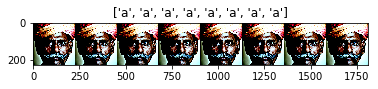

In [33]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
#     mean = np.array([0.485, 0.456, 0.406])
#     std = np.array([0.229, 0.224, 0.225])
#     inp = std * inp + mean
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
_inputs, classes = next(iter(dataloaders['train']))
print("_inputs.shape=",_inputs.shape)
# Make a grid from batch

inputs = _inputs[:,0:3,:,:]  # [-1,1]
# inputs = inputs*0.5+0.5 #不需要clip  #[0,1]
print("inputs min",np.min(inputs.numpy()))
print("inputs max",np.max(inputs.numpy()))

alphas = _inputs[:,3:4,:,:] #[-1,1]
# alphas = alphas*0.5+0.5 #不需要clip  #[0,1]
print("alphas min",np.min(alphas.numpy()))
print("alphas max",np.max(alphas.numpy()))

meanr = torch.mean(torch.FloatTensor(inputs[:,0,:,:])).numpy()
meang = torch.mean(torch.FloatTensor(inputs[:,1,:,:])).numpy()
meanb = torch.mean(torch.FloatTensor(inputs[:,2,:,:])).numpy()
meana = torch.mean(torch.FloatTensor(alphas[:,0,:,:])).numpy()

stdr = torch.std(torch.FloatTensor(inputs[:,0,:,:])).numpy()
stdg = torch.std(torch.FloatTensor(inputs[:,1,:,:])).numpy()
stdb = torch.std(torch.FloatTensor(inputs[:,2,:,:])).numpy()
stda = torch.std(torch.FloatTensor(alphas[:,0,:,:])).numpy()

print('inputs mean',meanr,meang,meanb,meana)
print('inputs std',stdr,stdg,stdb,stda)

out = torchvision.utils.make_grid(inputs)
imshow(out, title=[class_names[x] for x in classes])

# img = np_to_pil(alphas[0].numpy())
# img.show() #显示方法之一
# img.save('bb.png')



In [34]:
# vis.image(out,win='in')

Training the model
------------------

Now, let's write a general function to train a model. Here, we will
illustrate:

-  Scheduling the learning rate
-  Saving the best model

In the following, parameter ``scheduler`` is an LR scheduler object from
``torch.optim.lr_scheduler``.



In [35]:
def plotLosses():
    plt.plot(all_losses['train'],label='train')
    plt.plot(all_losses['val'],label='val')
    plt.legend()


Finetuning the convnet
----------------------

Load a pretrained model and reset final fully connected layer.




In [36]:
from models.skip import skip
from models.resnet import ResNet
from models.unet import UNet

pad = 'reflection'
OPT_OVER = 'net' # 'net,input'
reg_noise_std = 1./30. # set to 1./20. for sigma=50
show_every = 500
num_iter=2400
input_depth = 3
figsize = 5 
dtype = (torch.cuda.FloatTensor if torch.cuda.is_available() else torch.FloatTensor)

NETTYPE = 'skip'
if NETTYPE == 'skip':
    net = skip(
            input_depth, num_output_channels=1, 
            num_channels_down = [8, 16, 32, 64, 128, 256, 512],
            num_channels_up   = [8, 16, 32, 64, 128, 256, 512],
            num_channels_skip = [0,  0,  0,  0,   4,   4,   4], 
            upsample_mode='bilinear',
            need_sigmoid=True, need_bias=True, pad=pad, act_fun='LeakyReLU')
    LR = 0.002
elif NETTYPE == 'RESNET':
    net = ResNet(3, 1, 8, 32, need_sigmoid=True, act_fun='LeakyReLU')
    LR = 0.001
elif NETTYPE == 'UNet':
    net = UNet(num_input_channels=3, num_output_channels=1, 
           feature_scale=8, more_layers=1, 
           concat_x=False, upsample_mode='deconv', 
           pad='zero', norm_layer=torch.nn.InstanceNorm2d, need_sigmoid=True, need_bias=True)
    LR = 0.001
    

net = net.type(dtype)
# print(net)

In [37]:
# for param in net.parameters():
#     print(type(param.data), param.size())
#     print(param.data)

# s = sum([np.prod(list(p.size())) for p in net.parameters() ])
# print(s)

In [38]:
# weights initializing is far important than you imaging
# learn from inpainting
for n in [x for x in net.parameters()]:
    n.data.normal_()

In [39]:
model_ft = net

if use_gpu:
    model_ft = model_ft.cuda()

criterion = nn.MSELoss().type(dtype)

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=LR, momentum=0.9)
# optimizer_ft = optim.Adam(model_ft.parameters(), lr=LR)
# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=50, gamma=0.1)

In [40]:
def denomalize(nparray):
    return nparray*0.07552998+0.514

Train and evaluate
^^^^^^^^^^^^^^^^^^

It should take around 15-25 min on CPU. On GPU though, it takes less than a
minute.




In [41]:
def RGBAShow(rgb_np,a_np1=None,a_np2=None,phase = ''):
    if phase == 'val':return
    vis.image(denomalize(rgb_np),win = 100,opts=dict(title=phase+'_rgb'))
    #     np_to_pil(rgb_np).show()
    if a_np1 is not None:
        vis.image(denomalize(a_np1),win = 110,opts=dict(title=phase+'_a1'))
#         rgba1=np.concatenate((denomalize(rgb_np),denomalize(a_np1)),axis=0)
#         vis.image(rgba1,win=111,opts=dict(title=phase+'_rgba1'))
    if a_np2 is not None:
        vis.image(denomalize(a_np2),win = 120,opts=dict(title=phase+'_a2_mask'))
        #rgba2=np.concatenate((denomalize(rgb_np),denomalize(a_np2)),axis=0)
        #vis.image(rgba2,win=121,opts=dict(title=phase+'_rgba2'))

        

In [42]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_loss = 0.0
    all_losses={'train':[],'val':[]}
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)
        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                scheduler.step()
                model.train(True)  # Set model to training mode
            else:
                continue
                model.train(False)  # Set model to evaluate mode

            running_loss = 0.0
            
            # Iterate over data.
            for data in dataloaders[phase]:
                # get the inputs ,labels没有用，只是必须有这层结构
                _inputs, labels = data
                #把alpha通道拆出来，作为label,剩下的作为rgb3通道input
#                 print('_inputs.shape=',_inputs.shape)
                inputs = _inputs[:,0:3,:,:]
                labels = _inputs[:,2:3,:,:]
#                 labels = _inputs[:,3:4,:,:]
#                 labels = (labels-0.5)*2
                # wrap them in Variable
                if use_gpu:
                    inputs = Variable(inputs.cuda())
                    labels = Variable(labels.cuda())
                else:
                    inputs, labels = Variable(inputs), Variable(labels)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                outputs = model(inputs)
                
                #print('outputs mean =',torch.mean(outputs),torch.min(outputs),torch.max(outputs))
                print('========= outputs======',outputs[0,0,100:105,100:105])
                print('========= labels======',labels[0,0,100:105,100:105])
                loss = criterion(outputs, labels)
                if phase == 'train':
                    loss.backward()
                    optimizer.step()

                # statistics
                running_loss += loss.data.item() * inputs.size(0)
                #show sample
                RGBAShow(inputs.cpu().detach().numpy()[0], a_np1= labels.cpu().detach().numpy()[0], a_np2 = outputs.cpu().detach().numpy()[0],phase = phase)

            epoch_loss = running_loss / dataset_sizes[phase]
            all_losses[phase].append(epoch_loss)
            print('{} Loss: {:.4f}'.format(
                phase, epoch_loss))

            # deep copy the model
            if phase == 'train' and epoch_loss < best_loss:
                best_loss = epoch_loss
                best_model_wts = copy.deepcopy(model.state_dict())


            
    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
#     print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model,all_losses

In [43]:
model_ft,all_losses = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=220)

Epoch 0/219
----------
========= outputs====== tensor([[-0.8452, -0.8475, -0.8505, -0.8543, -0.8587],
        [-0.8571, -0.8589, -0.8611, -0.8641, -0.8676],
        [-0.8670, -0.8682, -0.8698, -0.8721, -0.8748],
        [-0.8749, -0.8756, -0.8766, -0.8782, -0.8803],
        [-0.8832, -0.8835, -0.8839, -0.8849, -0.8862]], device='cuda:0')
========= labels====== tensor([[-1.6270, -1.5953, -1.5318, -1.4684, -1.4050],
        [-1.6904, -1.6587, -1.6587, -1.6270, -1.5953],
        [-1.6270, -1.6587, -1.6587, -1.6587, -1.6587],
        [-1.3098, -1.4367, -1.5953, -1.6270, -1.6270],
        [-1.1195, -1.1671, -1.2781, -1.5636, -1.5953]], device='cuda:0')
train Loss: 1.5636
Epoch 1/219
----------


/home/yuan/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:1749: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


========= outputs====== tensor([[ 0.8561,  0.8739,  0.8843,  0.8875,  0.8866],
        [ 0.8679,  0.8833,  0.8930,  0.8969,  0.8965],
        [ 0.8785,  0.8916,  0.9004,  0.9045,  0.9044],
        [ 0.8875,  0.8984,  0.9061,  0.9101,  0.9101],
        [ 0.8943,  0.9035,  0.9098,  0.9128,  0.9127]], device='cuda:0')
========= labels====== tensor([[-1.6270, -1.5953, -1.5318, -1.4684, -1.4050],
        [-1.6904, -1.6587, -1.6587, -1.6270, -1.5953],
        [-1.6270, -1.6587, -1.6587, -1.6587, -1.6587],
        [-1.3098, -1.4367, -1.5953, -1.6270, -1.6270],
        [-1.1195, -1.1671, -1.2781, -1.5636, -1.5953]], device='cuda:0')
train Loss: 1.5339
Epoch 2/219
----------
========= outputs====== tensor([[ 0.6199,  0.6411,  0.6598,  0.6754,  0.6898],
        [ 0.5845,  0.6068,  0.6264,  0.6432,  0.6591],
        [ 0.5644,  0.5737,  0.5915,  0.6093,  0.6268],
        [ 0.5544,  0.5637,  0.5713,  0.5777,  0.5922],
        [ 0.5437,  0.5530,  0.5606,  0.5670,  0.5726]], device='cuda:0')
========

========= outputs====== tensor([[ 0.6905,  0.6882,  0.6867,  0.6856,  0.6843],
        [ 0.6872,  0.6853,  0.6841,  0.6833,  0.6822],
        [ 0.6834,  0.6819,  0.6810,  0.6804,  0.6795],
        [ 0.6788,  0.6776,  0.6770,  0.6765,  0.6758],
        [ 0.6737,  0.6726,  0.6718,  0.6709,  0.6697]], device='cuda:0')
========= labels====== tensor([[-1.6270, -1.5953, -1.5318, -1.4684, -1.4050],
        [-1.6904, -1.6587, -1.6587, -1.6270, -1.5953],
        [-1.6270, -1.6587, -1.6587, -1.6587, -1.6587],
        [-1.3098, -1.4367, -1.5953, -1.6270, -1.6270],
        [-1.1195, -1.1671, -1.2781, -1.5636, -1.5953]], device='cuda:0')
train Loss: 1.2781
Epoch 15/219
----------
========= outputs====== tensor([[ 0.1719,  0.1559,  0.1381,  0.1193,  0.0998],
        [ 0.1831,  0.1663,  0.1475,  0.1275,  0.1069],
        [ 0.1985,  0.1792,  0.1596,  0.1388,  0.1172],
        [ 0.2194,  0.1994,  0.1769,  0.1529,  0.1302],
        [ 0.2478,  0.2219,  0.1989,  0.1742,  0.1487]], device='cuda:0')
=======

========= outputs====== tensor([[ 0.7885,  0.7914,  0.7943,  0.7970,  0.8001],
        [ 0.7869,  0.7910,  0.7943,  0.7974,  0.8011],
        [ 0.7825,  0.7887,  0.7930,  0.7966,  0.8009],
        [ 0.7771,  0.7856,  0.7913,  0.7956,  0.8004],
        [ 0.7703,  0.7807,  0.7884,  0.7940,  0.7995]], device='cuda:0')
========= labels====== tensor([[-1.6270, -1.5953, -1.5318, -1.4684, -1.4050],
        [-1.6904, -1.6587, -1.6587, -1.6270, -1.5953],
        [-1.6270, -1.6587, -1.6587, -1.6587, -1.6587],
        [-1.3098, -1.4367, -1.5953, -1.6270, -1.6270],
        [-1.1195, -1.1671, -1.2781, -1.5636, -1.5953]], device='cuda:0')
train Loss: 1.2098
Epoch 28/219
----------
========= outputs====== tensor([[ 0.7193,  0.6987,  0.6760,  0.6508,  0.6243],
        [ 0.6987,  0.6776,  0.6547,  0.6289,  0.6011],
        [ 0.6749,  0.6534,  0.6298,  0.6025,  0.5761],
        [ 0.6462,  0.6247,  0.6003,  0.5714,  0.5492],
        [ 0.6146,  0.5933,  0.5700,  0.5426,  0.5253]], device='cuda:0')
=======

========= outputs====== tensor([[-0.1721, -0.1608, -0.1507, -0.1407, -0.1289],
        [-0.1830, -0.1716, -0.1613, -0.1512, -0.1418],
        [-0.1938, -0.1821, -0.1714, -0.1611, -0.1513],
        [-0.2043, -0.1921, -0.1810, -0.1703, -0.1601],
        [-0.2123, -0.2013, -0.1898, -0.1786, -0.1679]], device='cuda:0')
========= labels====== tensor([[-1.6270, -1.5953, -1.5318, -1.4684, -1.4050],
        [-1.6904, -1.6587, -1.6587, -1.6270, -1.5953],
        [-1.6270, -1.6587, -1.6587, -1.6587, -1.6587],
        [-1.3098, -1.4367, -1.5953, -1.6270, -1.6270],
        [-1.1195, -1.1671, -1.2781, -1.5636, -1.5953]], device='cuda:0')
train Loss: 1.1580
Epoch 41/219
----------
========= outputs====== tensor([[ 0.1861,  0.1794,  0.1823,  0.1940,  0.2051],
        [ 0.1925,  0.1845,  0.1851,  0.1945,  0.2049],
        [ 0.1952,  0.1882,  0.1873,  0.1933,  0.2024],
        [ 0.1942,  0.1896,  0.1883,  0.1909,  0.1986],
        [ 0.1928,  0.1905,  0.1889,  0.1884,  0.1945]], device='cuda:0')
=======

========= outputs====== tensor([[-0.2982, -0.2970, -0.2952, -0.2930, -0.2911],
        [-0.2969, -0.2955, -0.2937, -0.2915, -0.2896],
        [-0.2954, -0.2940, -0.2921, -0.2900, -0.2881],
        [-0.2936, -0.2922, -0.2903, -0.2883, -0.2864],
        [-0.2916, -0.2902, -0.2884, -0.2863, -0.2845]], device='cuda:0')
========= labels====== tensor([[-1.6270, -1.5953, -1.5318, -1.4684, -1.4050],
        [-1.6904, -1.6587, -1.6587, -1.6270, -1.5953],
        [-1.6270, -1.6587, -1.6587, -1.6587, -1.6587],
        [-1.3098, -1.4367, -1.5953, -1.6270, -1.6270],
        [-1.1195, -1.1671, -1.2781, -1.5636, -1.5953]], device='cuda:0')
train Loss: 1.1132
Epoch 54/219
----------
========= outputs====== tensor([[ 0.0497,  0.0881,  0.1430,  0.2326,  0.3065],
        [ 0.0356,  0.0758,  0.1168,  0.2121,  0.2927],
        [ 0.0214,  0.0626,  0.1053,  0.1855,  0.2773],
        [ 0.0107,  0.0520,  0.0957,  0.1592,  0.2611],
        [ 0.0016,  0.0423,  0.0869,  0.1319,  0.2448]], device='cuda:0')
=======

========= outputs====== tensor([[ 0.3464,  0.3316,  0.3170,  0.2999,  0.2845],
        [ 0.3326,  0.3154,  0.2995,  0.2823,  0.2675],
        [ 0.3169,  0.2980,  0.2816,  0.2653,  0.2520],
        [ 0.2990,  0.2791,  0.2632,  0.2490,  0.2381],
        [ 0.2783,  0.2591,  0.2450,  0.2337,  0.2256]], device='cuda:0')
========= labels====== tensor([[-1.6270, -1.5953, -1.5318, -1.4684, -1.4050],
        [-1.6904, -1.6587, -1.6587, -1.6270, -1.5953],
        [-1.6270, -1.6587, -1.6587, -1.6587, -1.6587],
        [-1.3098, -1.4367, -1.5953, -1.6270, -1.6270],
        [-1.1195, -1.1671, -1.2781, -1.5636, -1.5953]], device='cuda:0')
train Loss: 1.1873
Epoch 67/219
----------
========= outputs====== tensor([[-0.8807, -0.8690, -0.8597, -0.8536, -0.8476],
        [-0.8885, -0.8777, -0.8691, -0.8629, -0.8570],
        [-0.8962, -0.8864, -0.8782, -0.8719, -0.8658],
        [-0.9036, -0.8945, -0.8867, -0.8801, -0.8738],
        [-0.9096, -0.9011, -0.8935, -0.8869, -0.8805]], device='cuda:0')
=======

========= outputs====== tensor(1.00000e-02 *
       [[-3.7786, -3.6587, -3.5504, -3.4540, -3.3584],
        [-3.7987, -3.7082, -3.6192, -3.5340, -3.4501],
        [-3.8253, -3.7733, -3.7105, -3.6407, -3.5701],
        [-3.9252, -3.9159, -3.8827, -3.8306, -3.7723],
        [-4.0719, -4.1114, -4.1181, -4.0963, -4.0554]], device='cuda:0')
========= labels====== tensor([[-1.6270, -1.5953, -1.5318, -1.4684, -1.4050],
        [-1.6904, -1.6587, -1.6587, -1.6270, -1.5953],
        [-1.6270, -1.6587, -1.6587, -1.6587, -1.6587],
        [-1.3098, -1.4367, -1.5953, -1.6270, -1.6270],
        [-1.1195, -1.1671, -1.2781, -1.5636, -1.5953]], device='cuda:0')
train Loss: 1.0746
Epoch 80/219
----------
========= outputs====== tensor([[-0.1987, -0.1899, -0.1790, -0.1658, -0.1509],
        [-0.1977, -0.1900, -0.1799, -0.1670, -0.1522],
        [-0.1950, -0.1882, -0.1790, -0.1670, -0.1531],
        [-0.1897, -0.1835, -0.1754, -0.1648, -0.1527],
        [-0.1860, -0.1806, -0.1736, -0.1644, -0.1538]], dev

========= outputs====== tensor(1.00000e-02 *
       [[-3.7846, -3.1708, -2.2901, -1.2064, -0.1184],
        [-4.7969, -4.0369, -3.0681, -1.9148, -0.7521],
        [-5.7284, -4.8364, -3.7827, -2.5694, -1.3418],
        [-6.8849, -5.8606, -4.6794, -3.3586, -2.0459],
        [-7.9853, -6.8434, -5.5172, -4.0822, -2.7263]], device='cuda:0')
========= labels====== tensor([[-1.6270, -1.5953, -1.5318, -1.4684, -1.4050],
        [-1.6904, -1.6587, -1.6587, -1.6270, -1.5953],
        [-1.6270, -1.6587, -1.6587, -1.6587, -1.6587],
        [-1.3098, -1.4367, -1.5953, -1.6270, -1.6270],
        [-1.1195, -1.1671, -1.2781, -1.5636, -1.5953]], device='cuda:0')
train Loss: 1.0829
Epoch 93/219
----------
========= outputs====== tensor([[ 0.5997,  0.6102,  0.6182,  0.6239,  0.6278],
        [ 0.6067,  0.6178,  0.6264,  0.6328,  0.6371],
        [ 0.6141,  0.6255,  0.6346,  0.6416,  0.6460],
        [ 0.6231,  0.6344,  0.6434,  0.6506,  0.6550],
        [ 0.6307,  0.6418,  0.6508,  0.6581,  0.6625]], dev

========= outputs====== tensor(1.00000e-02 *
       [[-4.1159, -2.8907, -3.1823, -4.2817, -5.0923],
        [-4.3566, -3.2824, -3.5447, -4.6949, -5.6471],
        [-4.5595, -3.7769, -4.1043, -5.3588, -6.3195],
        [-4.6696, -4.3202, -4.8169, -6.0792, -7.0683],
        [-4.8832, -5.0605, -5.7055, -6.8543, -7.8349]], device='cuda:0')
========= labels====== tensor([[-1.6270, -1.5953, -1.5318, -1.4684, -1.4050],
        [-1.6904, -1.6587, -1.6587, -1.6270, -1.5953],
        [-1.6270, -1.6587, -1.6587, -1.6587, -1.6587],
        [-1.3098, -1.4367, -1.5953, -1.6270, -1.6270],
        [-1.1195, -1.1671, -1.2781, -1.5636, -1.5953]], device='cuda:0')
train Loss: 1.0154
Epoch 106/219
----------
========= outputs====== tensor(1.00000e-02 *
       [[-1.8289, -2.0850, -2.3901, -2.6198, -2.6901],
        [-2.1225, -2.3857, -2.6997, -2.9326, -3.0023],
        [-2.3627, -2.6210, -2.9431, -3.1919, -3.2693],
        [-2.5056, -2.7254, -3.0214, -3.2701, -3.3470],
        [-2.5952, -2.6250, -2.7248, -

========= outputs====== tensor([[-0.3419, -0.2702, -0.1943, -0.1116, -0.0309],
        [-0.3409, -0.2729, -0.2007, -0.1217, -0.0454],
        [-0.3337, -0.2672, -0.1981, -0.1251, -0.0559],
        [-0.3224, -0.2555, -0.1893, -0.1253, -0.0667],
        [-0.3080, -0.2391, -0.1759, -0.1229, -0.0756]], device='cuda:0')
========= labels====== tensor([[-1.6270, -1.5953, -1.5318, -1.4684, -1.4050],
        [-1.6904, -1.6587, -1.6587, -1.6270, -1.5953],
        [-1.6270, -1.6587, -1.6587, -1.6587, -1.6587],
        [-1.3098, -1.4367, -1.5953, -1.6270, -1.6270],
        [-1.1195, -1.1671, -1.2781, -1.5636, -1.5953]], device='cuda:0')
train Loss: 1.0609
Epoch 118/219
----------
========= outputs====== tensor(1.00000e-02 *
       [[ 6.4829,  6.3992,  6.3820,  6.3889,  6.4292],
        [ 5.8578,  5.7804,  5.7631,  5.7679,  5.7964],
        [ 5.4205,  5.3504,  5.3256,  5.3121,  5.3058],
        [ 5.1835,  5.1288,  5.0924,  5.0445,  4.9736],
        [ 5.0600,  5.0365,  5.0058,  4.9433,  4.8141]], de

========= outputs====== tensor([[ 0.4572,  0.4184,  0.3723,  0.3132,  0.2333],
        [ 0.3795,  0.3327,  0.2763,  0.2073,  0.1503],
        [ 0.3130,  0.2584,  0.2034,  0.1545,  0.0827],
        [ 0.2383,  0.2026,  0.1524,  0.0867,  0.0220],
        [ 0.1930,  0.1488,  0.0899,  0.0163, -0.0048]], device='cuda:0')
========= labels====== tensor([[-1.6270, -1.5953, -1.5318, -1.4684, -1.4050],
        [-1.6904, -1.6587, -1.6587, -1.6270, -1.5953],
        [-1.6270, -1.6587, -1.6587, -1.6587, -1.6587],
        [-1.3098, -1.4367, -1.5953, -1.6270, -1.6270],
        [-1.1195, -1.1671, -1.2781, -1.5636, -1.5953]], device='cuda:0')
train Loss: 1.1034
Epoch 131/219
----------
========= outputs====== tensor([[-0.9090, -0.9052, -0.8991, -0.8900, -0.8768],
        [-0.9120, -0.9082, -0.9022, -0.8934, -0.8805],
        [-0.9134, -0.9096, -0.9037, -0.8952, -0.8825],
        [-0.9127, -0.9091, -0.9034, -0.8950, -0.8824],
        [-0.9116, -0.9082, -0.9025, -0.8942, -0.8815]], device='cuda:0')
======

========= outputs====== tensor([[ 0.7954,  0.7748,  0.7456,  0.7071,  0.6590],
        [ 0.7823,  0.7605,  0.7290,  0.6905,  0.6380],
        [ 0.7668,  0.7425,  0.7112,  0.6698,  0.6124],
        [ 0.7505,  0.7253,  0.6918,  0.6464,  0.5835],
        [ 0.7370,  0.7081,  0.6697,  0.6193,  0.5504]], device='cuda:0')
========= labels====== tensor([[-1.6270, -1.5953, -1.5318, -1.4684, -1.4050],
        [-1.6904, -1.6587, -1.6587, -1.6270, -1.5953],
        [-1.6270, -1.6587, -1.6587, -1.6587, -1.6587],
        [-1.3098, -1.4367, -1.5953, -1.6270, -1.6270],
        [-1.1195, -1.1671, -1.2781, -1.5636, -1.5953]], device='cuda:0')
train Loss: 1.0606
Epoch 144/219
----------
========= outputs====== tensor([[-0.3512, -0.3456, -0.3418, -0.3413, -0.3442],
        [-0.3605, -0.3552, -0.3512, -0.3487, -0.3480],
        [-0.3702, -0.3651, -0.3609, -0.3573, -0.3543],
        [-0.3805, -0.3756, -0.3712, -0.3673, -0.3635],
        [-0.3919, -0.3868, -0.3821, -0.3776, -0.3729]], device='cuda:0')
======

========= outputs====== tensor(1.00000e-02 *
       [[-7.8464, -7.6283, -7.3016, -6.9105, -6.5494],
        [-7.8064, -7.7473, -7.5781, -7.3269, -7.0170],
        [-7.8118, -7.8704, -7.8228, -7.6918, -7.4566],
        [-7.6701, -7.7644, -7.7672, -7.7036, -7.5632],
        [-7.5183, -7.6179, -7.6357, -7.5866, -7.4861]], device='cuda:0')
========= labels====== tensor([[-1.6270, -1.5953, -1.5318, -1.4684, -1.4050],
        [-1.6904, -1.6587, -1.6587, -1.6270, -1.5953],
        [-1.6270, -1.6587, -1.6587, -1.6587, -1.6587],
        [-1.3098, -1.4367, -1.5953, -1.6270, -1.6270],
        [-1.1195, -1.1671, -1.2781, -1.5636, -1.5953]], device='cuda:0')
train Loss: 1.0719
Epoch 157/219
----------
========= outputs====== tensor(1.00000e-02 *
       [[-7.3021, -6.9580, -6.5509, -5.7711, -4.7518],
        [-6.7084, -6.3839, -5.9963, -5.2358, -4.2399],
        [-6.0885, -5.7811, -5.4124, -4.6565, -3.6882],
        [-5.5503, -5.2502, -4.8931, -4.1529, -3.2074],
        [-5.0517, -4.7488, -4.3971, -

========= outputs====== tensor([[ 0.3685,  0.3705,  0.3743,  0.3801,  0.3898],
        [ 0.3869,  0.3886,  0.3918,  0.3972,  0.4074],
        [ 0.4035,  0.4072,  0.4140,  0.4256,  0.4550],
        [ 0.4184,  0.4244,  0.4368,  0.4635,  0.4970],
        [ 0.4510,  0.4650,  0.4854,  0.5110,  0.5417]], device='cuda:0')
========= labels====== tensor([[-1.6270, -1.5953, -1.5318, -1.4684, -1.4050],
        [-1.6904, -1.6587, -1.6587, -1.6270, -1.5953],
        [-1.6270, -1.6587, -1.6587, -1.6587, -1.6587],
        [-1.3098, -1.4367, -1.5953, -1.6270, -1.6270],
        [-1.1195, -1.1671, -1.2781, -1.5636, -1.5953]], device='cuda:0')
train Loss: 0.9393
Epoch 170/219
----------
========= outputs====== tensor([[ 0.9965,  0.9972,  0.9978,  0.9982,  0.9985],
        [ 0.9958,  0.9967,  0.9974,  0.9979,  0.9982],
        [ 0.9951,  0.9963,  0.9972,  0.9976,  0.9980],
        [ 0.9945,  0.9956,  0.9968,  0.9974,  0.9978],
        [ 0.9939,  0.9954,  0.9964,  0.9972,  0.9978]], device='cuda:0')
======

========= outputs====== tensor([[ 0.7183,  0.7159,  0.7124,  0.7089,  0.7093],
        [ 0.6461,  0.6499,  0.6517,  0.6528,  0.6591],
        [ 0.5497,  0.5624,  0.5719,  0.5799,  0.5949],
        [ 0.4312,  0.4562,  0.4769,  0.4955,  0.5208],
        [ 0.2927,  0.3360,  0.3722,  0.4056,  0.4429]], device='cuda:0')
========= labels====== tensor([[-1.6270, -1.5953, -1.5318, -1.4684, -1.4050],
        [-1.6904, -1.6587, -1.6587, -1.6270, -1.5953],
        [-1.6270, -1.6587, -1.6587, -1.6587, -1.6587],
        [-1.3098, -1.4367, -1.5953, -1.6270, -1.6270],
        [-1.1195, -1.1671, -1.2781, -1.5636, -1.5953]], device='cuda:0')
train Loss: 1.0696
Epoch 183/219
----------
========= outputs====== tensor([[-0.3515, -0.3593, -0.3674, -0.3757, -0.3839],
        [-0.3481, -0.3577, -0.3675, -0.3776, -0.3871],
        [-0.3460, -0.3573, -0.3686, -0.3800, -0.3902],
        [-0.3458, -0.3572, -0.3687, -0.3801, -0.3907],
        [-0.3461, -0.3573, -0.3687, -0.3802, -0.3911]], device='cuda:0')
======

========= outputs====== tensor([[-0.1570, -0.1555, -0.1519, -0.1483, -0.1473],
        [-0.1539, -0.1574, -0.1531, -0.1489, -0.1473],
        [-0.1490, -0.1548, -0.1549, -0.1500, -0.1479],
        [-0.1418, -0.1488, -0.1522, -0.1512, -0.1489],
        [-0.1320, -0.1409, -0.1458, -0.1475, -0.1493]], device='cuda:0')
========= labels====== tensor([[-1.6270, -1.5953, -1.5318, -1.4684, -1.4050],
        [-1.6904, -1.6587, -1.6587, -1.6270, -1.5953],
        [-1.6270, -1.6587, -1.6587, -1.6587, -1.6587],
        [-1.3098, -1.4367, -1.5953, -1.6270, -1.6270],
        [-1.1195, -1.1671, -1.2781, -1.5636, -1.5953]], device='cuda:0')
train Loss: 1.2487
Epoch 196/219
----------
========= outputs====== tensor([[ 0.8276,  0.8133,  0.7998,  0.7880,  0.7764],
        [ 0.8114,  0.7961,  0.7815,  0.7686,  0.7565],
        [ 0.7944,  0.7780,  0.7624,  0.7484,  0.7357],
        [ 0.7763,  0.7587,  0.7420,  0.7271,  0.7138],
        [ 0.7574,  0.7384,  0.7207,  0.7050,  0.6909]], device='cuda:0')
======

========= outputs====== tensor([[-0.3588, -0.3277, -0.2973, -0.2685, -0.2600],
        [-0.3906, -0.3563, -0.3228, -0.2883, -0.2662],
        [-0.4267, -0.3909, -0.3541, -0.3149, -0.2750],
        [-0.4645, -0.4276, -0.3880, -0.3444, -0.2995],
        [-0.4989, -0.4618, -0.4213, -0.3763, -0.3290]], device='cuda:0')
========= labels====== tensor([[-1.6270, -1.5953, -1.5318, -1.4684, -1.4050],
        [-1.6904, -1.6587, -1.6587, -1.6270, -1.5953],
        [-1.6270, -1.6587, -1.6587, -1.6587, -1.6587],
        [-1.3098, -1.4367, -1.5953, -1.6270, -1.6270],
        [-1.1195, -1.1671, -1.2781, -1.5636, -1.5953]], device='cuda:0')
train Loss: 1.0676
Epoch 209/219
----------
========= outputs====== tensor([[-0.1544, -0.1521, -0.1498, -0.1476, -0.1456],
        [-0.1557, -0.1529, -0.1504, -0.1481, -0.1461],
        [-0.1590, -0.1548, -0.1523, -0.1498, -0.1464],
        [-0.1646, -0.1588, -0.1563, -0.1537, -0.1444],
        [-0.1709, -0.1636, -0.1611, -0.1527, -0.1427]], device='cuda:0')
======

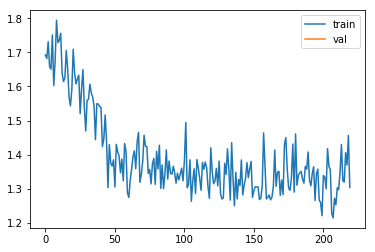

In [23]:
plotLosses()

In [24]:
# Show a picture 

# Get a batch of training data
_inputs, classes = next(iter(dataloaders['train']))
print("_inputs.shape=",_inputs.shape)
# Make a grid from batch
inputs = _inputs[:,0:3,:,:]

# print(inputs[0])
inputs_a = _inputs[:,3:4,:,:]
if use_gpu:
    inputs = Variable(inputs.cuda())

model_ft.train(False)    
outs = model_ft(inputs)


_inputs.shape= torch.Size([8, 4, 224, 224])


/home/yuan/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:1749: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


In [25]:
rgb_batch = inputs.cpu().detach().numpy()
np_to_pil(rgb_batch[0]).save('rgb.jpg')

a2_batch = outs.cpu().detach().numpy()
a1_batch = inputs_a.cpu().detach().numpy()
rgba_batch = np.concatenate((rgb_batch,a2_batch),axis=1)

rgba_np=rgba_batch[1]
rgba_pil = np_to_pil(rgba_np)
rgba_pil.show()
rgba_pil.save('rgba.png')



In [17]:
RGBAShow(rgb_batch[0],a_np1=a1_batch[0],a_np2=a2_batch[0])


NameError: name 'rgb_batch' is not defined

In [ ]:
# def RGBAShowBatch(rgb_np,a_np):
#     out_np = np.concatenate((rgb_np,a_np),axis=1)
#     vis.images(out_np,win='out',opts=dict(caption='out list'),)

# RGBAShowBatch(rgb_batch,a_batch)

In [ ]:
np.min(a2_batch)

In [ ]:
np_to_pil(inputs.cpu().detach().numpy()[0]).save('input.jpg')

In [52]:
np_to_pil(ii[0:3,:,:]).save('_input.png')

In [ ]:
model_ft